<a href="https://colab.research.google.com/github/QuratulAin20/AI-agents/blob/main/Reflexion_AI_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reflexion agent
It address the drawback of reflection system i.e
1. In reflection system the refelction is not grounded in live data, it just the result of llm prompting mean we are only relying on training data of LLM.
2. This can cause hallucination or we can get out dated content.

An architecture designed to learn through verbal feedback and self-reflection.
where as basic reflection agent only learn through self-assessing not by verbal feedback.

- verbal feedback mean critics response base upon external data sources by using APIs.

### Component of Reflexion agent
1. `Actor` agent with self reflection a main component that derive everything.
##### Sub-component of actor
  1. `external evaluator` an external tool for verbal feedback.
  2. `intial responder` generates an initial response and self-reflect.
  3. `revisor` re-respond and reflect based upon the previous reflection.

2. Second main component of Reflexion agent is `episodic memory` aim to recall past interaction, events or experiences make agent more context-awared.


The `actor agent` explicitly critiques each response and grounds its criticism in external data. It is forced to generate citations and explicitly enumerate superfluous(something that is unnecessary or excessive) and missing aspects of the generated response. This makes the content of the reflections more constructive and better steers the generator in responding to the feedback.

### Working or conversational flow
1. the first node is our first responder i.e, draft. It generate a response.
2. Initial response has 3 properties to check
  i. response : have initial response
  ii. critique: have self criticism on response
  iii. search: Contain certain keyword for search
3. Now we have initial reponse and ready to send it to external tool.
3. We have both initial response and external data ready next send it to another agent i.e rivisor.
4. Revisor look through the initial response and live data and then generate revise reponse.
5. Revise response contain 4 properties
  i. revise reponse
  ii. revise critic
  iii. revise search
  iv. citation
  
  If it is according to desired reponse then it generate output, otherwise it will send back to execution tool for further enhancement till n-times.

### code
```python

from langgraph.graph import END, MessageGraph

MAX_ITERATIONS = 5
builder = MessageGraph()
builder.add_node("draft", first_responder.respond)
builder.add_node("execute_tools", execute_tools)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:
def event_loop(state: List[BaseMessage]) -> str:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.set_entry_point("draft")
graph = builder.compile()

```



# Building a Reflexion AI agent architecture

In [1]:
%pip install -U --quiet  langgraph
%pip install -U --quiet tavily-python
%pip install -qU langchain-groq
%pip install -U --quiet langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00


In [2]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("GROQ_API_KEY")

TAVILY_API_KEY··········
GROQ_API_KEY··········


In [3]:
# Define LLM
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.5,
    max_tokens=500,
    timeout=None,
    max_retries=2,
)

# Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:

- Tools/tool execution
- Initial responder: generate an initial response (and self-reflection)
- Revisor: re-respond (and reflec) based on previous reflections

We'll first define the tool execution context.

In [4]:
# contructing tool, here we are using Tavily, we can also use wikipedia or arxiv


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

In [5]:
# defining initial responder, here we are using pydantic from langchain as a validator. so we have AI responder with `reflection` and `validator` both

from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}



#### code explanation

### Key Components

1. **Reflection Class**:
   - A Pydantic model that captures critiques of an AI's response.
   - Contains two fields: `missing` and `superfluous`.

   ```python
   class Reflection(BaseModel):
       missing: str = Field(description="Critique of what is missing.")
       superfluous: str = Field(description="Critique of what is superfluous")
   ```

2. **AnswerQuestion Class**:
   - Another Pydantic model designed to structure the AI's response.
   - Includes the `answer`, `reflection`, and a list of `search_queries`.

   ```python
   class AnswerQuestion(BaseModel):
       answer: str = Field(description="~250 word detailed answer to the question.")
       reflection: Reflection = Field(description="Your reflection on the initial answer.")
       search_queries: list[str] = Field(
           description="1-3 search queries for researching improvements."
       )
   ```

3. **ResponderWithRetries Class**:
   - A class that attempts to generate a response multiple times (up to three).
   - Utilizes a `runnable` to invoke the response generation and a `validator` to check for validity.

   ```python
   class ResponderWithRetries:
       def __init__(self, runnable, validator):
           self.runnable = runnable
           self.validator = validator

       def respond(self, state: dict):
           response = []
           for attempt in range(3):
               response = self.runnable.invoke(
                   {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
               )
               try:
                   self.validator.invoke(response)
                   return {"messages": response}
               except ValidationError as e:
                   state = state + [
                       response,
                       ToolMessage(
                           content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                           + self.validator.schema_json()
                           + " Respond by fixing all validation errors.",
                           tool_call_id=response.tool_calls[0]["id"],
                       ),
                   ]
           return {"messages": response}
   ```

### Functionality

- **Response Generation**: The `ResponderWithRetries` class aims to generate a detailed answer while ensuring it adheres to the expected schema.
- **Validation**: If the response does not match the schema, it captures the error and prompts the user to correct it.
- **Reflection**: The generated answer includes a reflection on its quality, identifying areas that are missing or superfluous.

In [6]:
# defining prompt for actor agent

import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)



In [7]:
# checking our actor agent
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

In [8]:
print(initial["messages"])

content='' additional_kwargs={'tool_calls': [{'id': 'call_6a4e', 'function': {'arguments': '{"answer":"Reflection is useful in AI as it enables the system to evaluate its own performance, identify areas of improvement, and adapt to new situations. Through reflection, AI systems can analyze their decision-making processes, recognize biases, and adjust their algorithms to produce more accurate results. This self-awareness allows AI to learn from its mistakes, refine its knowledge, and develop more effective problem-solving strategies. Moreover, reflection in AI can facilitate transparency, explainability, and trustworthiness, which are essential for human-AI collaboration and decision-making. By reflecting on its actions and outcomes, AI can provide insights into its reasoning and decision-making processes, making it more reliable and accountable. Overall, reflection is a crucial component of AI development, as it enables the creation of more intelligent, flexible, and human-centered sys

In [9]:
# defining the second part of actor agent i.e revision

revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

    # Add the references field
    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)


In [10]:
print(initial["messages"].tool_calls)

[{'name': 'AnswerQuestion', 'args': {'answer': 'Reflection is useful in AI as it enables the system to evaluate its own performance, identify areas of improvement, and adapt to new situations. Through reflection, AI systems can analyze their decision-making processes, recognize biases, and adjust their algorithms to produce more accurate results. This self-awareness allows AI to learn from its mistakes, refine its knowledge, and develop more effective problem-solving strategies. Moreover, reflection in AI can facilitate transparency, explainability, and trustworthiness, which are essential for human-AI collaboration and decision-making. By reflecting on its actions and outcomes, AI can provide insights into its reasoning and decision-making processes, making it more reliable and accountable. Overall, reflection is a crucial component of AI development, as it enables the creation of more intelligent, flexible, and human-centered systems.', 'reflection': {'missing': 'The current answer l

In [11]:
import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial["messages"].tool_calls[0]["id"],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"][
                                "search_queries"
                            ][0]
                        }
                    )
                ),
            ),
        ]
    }
)
revised["messages"]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ywsb', 'function': {'arguments': '{"answer": "Reflection is a crucial component of AI development, enabling systems to evaluate their performance, identify areas of improvement, and adapt to new situations. Through reflection, AI systems can analyze their decision-making processes, recognize biases, and adjust their algorithms to produce more accurate results. This self-awareness allows AI to learn from its mistakes, refine its knowledge, and develop more effective problem-solving strategies. For instance, reflection can be applied in self-modifying code or meta-learning algorithms, where AI systems can modify their own architecture or learning objectives based on their performance [1]. Moreover, reflection in AI can facilitate transparency, explainability, and trustworthiness, which are essential for human-AI collaboration and decision-making. According to recent studies, reflection can improve the quality and succes

## Creating tool node
Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool

In [13]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)


## Construct Graph
Now we can wire all our components together.

In [17]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 2
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()


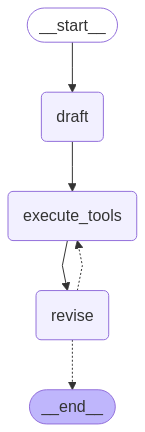

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [18]:

events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_1q3n)
 Call ID: call_1q3n
  Args:
    answer: To handle the climate crisis, we must adopt a multi-faceted approach that involves both individual and collective actions. Firstly, governments and corporations must prioritize sustainable practices, such as investing in renewable energy sources, increasing energy efficiency, and implementing policies to reduce greenhouse gas emissions. Additionally, individuals can make a significant impact by making conscious choices in their daily lives, such as reducing meat consumption, using public transport, and conserving water. Furthermore, it is essential to support climate change research and development of new technologies that can help mitigate the effects of climate change. We must also work tog